In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

In [4]:
df_train['title_lemmatized'] = df_train['title_lemmatized'].apply(lambda x: eval(x))
df_val['title_lemmatized'] = df_val['title_lemmatized'].apply(lambda x: eval(x))
df_test['title_lemmatized'] = df_test['title_lemmatized'].apply(lambda x: eval(x))

df_train['text_lemmatized'] = df_train['text_lemmatized'].apply(lambda x: eval(x))
df_val['text_lemmatized'] = df_val['text_lemmatized'].apply(lambda x: eval(x))          
df_test['text_lemmatized'] = df_test['text_lemmatized'].apply(lambda x: eval(x))

df_train['tokens'] = df_train['title_lemmatized'] + df_train['text_lemmatized']
df_val['tokens'] = df_val['title_lemmatized'] + df_val['text_lemmatized']   
df_test['tokens'] = df_test['title_lemmatized'] + df_test['text_lemmatized']

In [5]:
def load_glove_dict(file_path, dim=100):
    glove_dict = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            glove_dict[word] = vector
    return glove_dict

glove_path = "glove.6B.100d.txt"
glove_dim = 100
glove_dict = load_glove_dict(glove_path, dim=glove_dim)

In [ ]:
def tokens_to_sequence(tokens, glove_dict, dim=100, max_len=256):
    vectors = [glove_dict.get(tok, np.zeros(dim)) for tok in tokens]
    mask = [1]*len(vectors)
    if len(vectors) > max_len:
        vectors = vectors[:max_len]
        mask = mask[:max_len]
    else:
        padding_len = max_len - len(vectors)
        vectors += [np.zeros(dim)] * padding_len
        mask += [0] * padding_len
    return torch.tensor(np.array(vectors), dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [7]:
def create_and_save_embeddings(df, split_name, glove_dict, dim=100, max_len=256):
    os.makedirs(f"{split_name}_glove_embeddings", exist_ok=True)
    for idx, tokens in enumerate(df['tokens']):
        emb, mask = tokens_to_sequence(tokens, glove_dict, dim, max_len)
        np.save(f"{split_name}_glove_embeddings/embedding_{idx}.npy", emb.numpy())
        np.save(f"{split_name}_glove_embeddings/mask_{idx}.npy", mask.numpy())

In [8]:
create_and_save_embeddings(df_train, "train", glove_dict, glove_dim)
create_and_save_embeddings(df_val, "val", glove_dict, glove_dim)
create_and_save_embeddings(df_test, "test", glove_dict, glove_dim)

In [9]:
y_train = df_train['label'].tolist()
y_val = df_val['label'].tolist()
y_test = df_test['label'].tolist()

In [10]:
def load_glove_embedding(idx, folder_path):
    emb = np.load(f"{folder_path}/embedding_{idx}.npy")
    mask = np.load(f"{folder_path}/mask_{idx}.npy")
    return torch.tensor(emb, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [11]:
def create_batch(indices, folder_path, labels=None):
    embeddings, masks, batch_labels = [], [], []

    for idx in indices:
        emb, mask = load_glove_embedding(idx, folder_path)
        embeddings.append(emb)
        masks.append(mask)
        if labels is not None:
            batch_labels.append(labels[idx])

    embeddings = torch.stack(embeddings).to(device)
    masks = torch.stack(masks).to(device)

    if labels is not None:
        batch_labels = torch.tensor(batch_labels).to(device)
        return embeddings, masks, batch_labels
    else:
        return embeddings, masks

In [12]:
embedding_dim = glove_dim
hidden_dim = 256
num_classes = 2

lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
linear = nn.Linear(hidden_dim * 2, num_classes)

lstm = lstm.to(device)
linear = linear.to(device)

In [13]:
def evaluate(lstm, linear, folder_path, labels, batch_size=32):
    lstm.eval()
    linear.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for i in range(0, len(labels), batch_size):
            batch_idx = list(range(i, min(i+batch_size, len(labels))))
            embeddings, masks, lbls = create_batch(batch_idx, folder_path, labels)

            outputs, _ = lstm(embeddings)
            lengths = masks.sum(dim=1) - 1
            last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
            logits = linear(last_outputs)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(lbls.cpu())

    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)
    acc = (y_pred == y_true).float().mean().item()
    return y_pred, y_true, acc

In [14]:
history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(lstm.parameters()) + list(linear.parameters()), lr=1e-4)
num_epochs = 5
batch_size = 16

train_folder = "train_glove_embeddings"
val_folder = "val_glove_embeddings"
test_folder = "test_glove_embeddings"

for epoch in range(num_epochs):
    lstm.train()
    linear.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    indices = list(range(len(y_train)))
    np.random.shuffle(indices)

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        embeddings, masks, labels = create_batch(batch_indices, train_folder, y_train)

        optimizer.zero_grad()
        outputs, _ = lstm(embeddings)

        lengths = masks.sum(dim=1) - 1
        last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
        logits = linear(last_outputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    train_acc = (torch.cat(all_preds) == torch.cat(all_labels)).float().mean().item()
    _, _, val_acc = evaluate(lstm, linear, val_folder, y_val, batch_size=batch_size)
    _, _, test_acc = evaluate(lstm, linear, test_folder, y_test, batch_size=batch_size)

    history['train_loss'].append(total_loss / (len(indices) / batch_size))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {history['train_loss'][-1]:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/5 | Loss: 0.5264 | Train Acc: 0.7317 | Val Acc: 0.7435 | Test Acc: 0.7447
Epoch 2/5 | Loss: 0.4484 | Train Acc: 0.7813 | Val Acc: 0.7949 | Test Acc: 0.7915
Epoch 3/5 | Loss: 0.4098 | Train Acc: 0.8019 | Val Acc: 0.8287 | Test Acc: 0.8231
Epoch 4/5 | Loss: 0.4401 | Train Acc: 0.7883 | Val Acc: 0.8254 | Test Acc: 0.8223
Epoch 5/5 | Loss: 0.4015 | Train Acc: 0.8046 | Val Acc: 0.8247 | Test Acc: 0.8138


In [15]:
pd.DataFrame(history).to_csv("glove_lstm_history.csv", index=False)

In [16]:
y_pred, y_true, _ = evaluate(lstm, linear, test_folder, y_test, batch_size=batch_size)

print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, digits=4))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.8204    0.8524    0.8361      6883
           1     0.8047    0.7653    0.7845      5471

    accuracy                         0.8138     12354
   macro avg     0.8126    0.8088    0.8103     12354
weighted avg     0.8135    0.8138    0.8133     12354



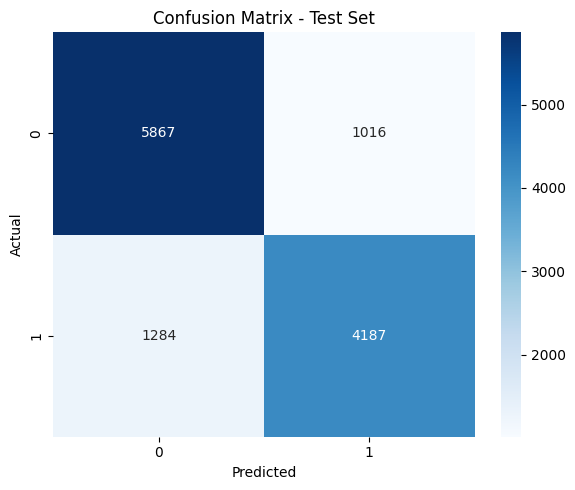

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()

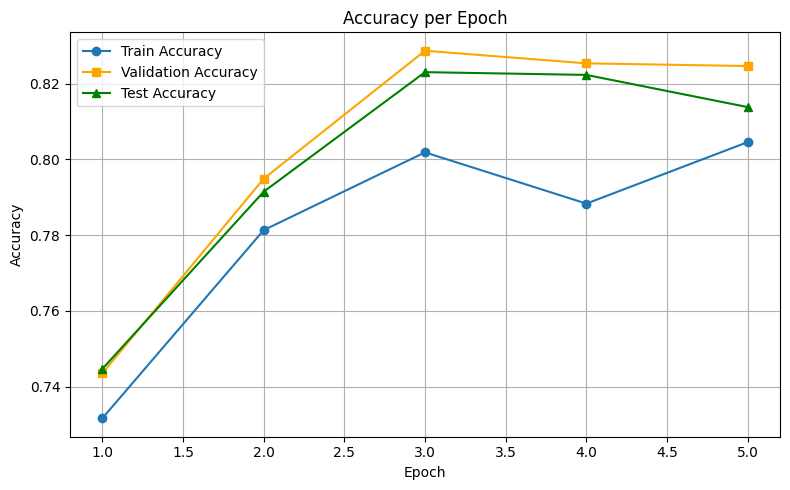

In [18]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='s', color='orange')
plt.plot(epochs, history['test_acc'], label='Test Accuracy', marker='^', color='green')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [19]:
torch.save(lstm.state_dict(), "glove_lstm_model.pt")
torch.save(linear.state_dict(), "glove_lstm_linear.pt")